In [1]:
def generate_conversion_rate(prices):
    val = np.random.uniform(size=(len(prices)))
    conversion_rates = np.sort(val)[::-1]
    return conversion_rates

In [2]:
import matplotlib.pyplot as plt
from mab.environment import *
from mab.ts_learner import *
from mab.ucb_learner import *

n_experiments = 365
#Customers
customerParams = zip([25, 25, 25, 25], [5,5,5,5])
n_classes = 4
#discounts
discounts = np.array([0.0, 0.5, 0.10, 0.25])
                    
prices1 = np.cumsum(np.linspace(100,300, num=6))
prices2 = np.array([300])
conv_rate1 = np.array([generate_conversion_rate(prices1) for x in range(n_classes)])
conv_rate2 = np.reshape(generate_conversion_rate(range(n_classes)), (4,1))

arms = prices1 + conv_rate2*prices2 #TODO:Add fractions for item2
print(conv_rate2)

[[0.65826904]
 [0.448836  ]
 [0.19096809]
 [0.1136837 ]]


In [3]:
customerParams = zip([25, 25, 25, 25], [5,5,5,5])
env = Environment(customerParams, discounts, prices1, conv_rate1, conv_rate2)
ts_learner =TS_Learner(arms=arms)      
u_learner = UCB(arms=arms)
ts_learner_for_conv2 = TS_Learner(arms=np.transpose(conv_rate2))

#print(ts_learner_for_conv2.beta_parameters)

ts_rewards_all = []
u_rewards_all = []
c_rewards_all = []

for day in range(n_experiments):
    arms = prices1 + conv_rate2*prices2 #TODO in step4: update arms by pulling conv_rate2 from ts_learner_for_conv2
    ts_rewards_per_experiment = [] 
    u_rewards_per_experiment = []
    c_rewards_per_experiment = []
    
    customers = [[(c, cust) for cust in range(size)] for c, size in enumerate(env.customers)]
    customers = [item for sublist in customers for item in sublist]
    random.shuffle(customers) #Shuffling clients avoids unbiases learners towards the first class

    for cust in customers:

        ts_pulled_arm = ts_learner.pull_arm2()#Pulls without considering the amount of customers per class
        ts_reward = env.round1(ts_pulled_arm, cust)#Rounds considering the ACTUAL customer class
        ts_learner.update(ts_pulled_arm, ts_reward)
        
        ts_pulled_arm_conv2 = ts_learner_for_conv2.pull_arm2()
        ts_learner_for_conv2.update(ts_pulled_arm_conv2, ts_reward)
        
        ts_rewards_per_experiment.append(np.array(arms)[ts_pulled_arm]*np.array(ts_reward))


        u_pulled_arm = u_learner.pull_arm2() #Pulls considering the amount of customers per class
        u_reward = env.round1(u_pulled_arm, cust)#Rounds considering the ACTUAL customer class
        u_learner.update(u_pulled_arm, u_reward)

        u_rewards_per_experiment.append(np.array(arms)[u_pulled_arm]*np.array(u_reward))

        #Maximum expected reward for a client obtainable from a member of class cust[0]
        c_rewards_per_experiment.append(np.max(conv_rate1[cust[0]]*prices1 + conv_rate2[cust[0]]*prices2))
        

        #TODO in step4: update ts_learner_for_conv2 beta parameters
        #idx = np.unravel_index(ts_learner_for_conv2.beta_parameters.argmax(),ts_learner_for_conv2.beta_parameters.shape)
        #print(ts_learner_for_conv2.beta_parameters[idx])
        #print(ts_learner_for_conv2.beta_parameters)
        #conv_rate2 = [x = conv_rate2[idx[1]] for x in range(n_classes)]
        #print(conv_rate2)

    
    ts_rewards_all.append(ts_rewards_per_experiment)
    u_rewards_all.append(u_rewards_per_experiment)
    c_rewards_all.append(c_rewards_per_experiment)

Text(0, 0.5, 'Cumulative Mean Reward')

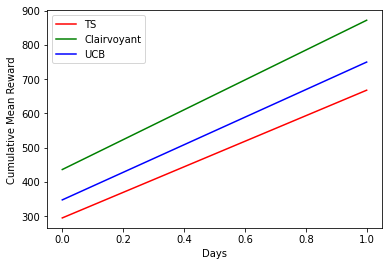

In [4]:
plt.plot(np.cumsum(np.mean(ts_rewards_all, axis=1)), color='red', label='TS')
plt.plot(np.cumsum(np.mean(c_rewards_all, axis=1)), color='green', label='Clairvoyant')
plt.plot(np.cumsum(np.mean(u_rewards_all, axis=1)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Cumulative Mean Reward')

In [5]:
from scipy.signal import savgol_filter

plt.plot(np.mean(ts_rewards_all, axis=1), alpha=0.1, color='red')
plt.plot(np.mean(c_rewards_all, axis=1), color='green', label='Clairvoyant')
plt.plot(np.mean(u_rewards_all, axis=1), alpha=0.1, color='blue')

plt.plot(savgol_filter(np.mean(ts_rewards_all, axis=1), 75, 3), color='red', label='TS') #Cubic interpolation
plt.plot(savgol_filter(np.mean(u_rewards_all, axis=1), 75, 3), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Mean Reward')

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

Text(0, 0.5, 'Regret')

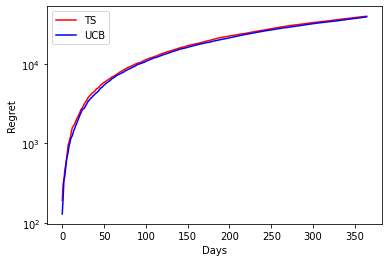

In [6]:
plt.plot(np.cumsum(np.mean(np.array(c_rewards_all) - np.array(ts_rewards_all), axis=1)), color='red', label='TS')
plt.plot(np.cumsum(np.mean(np.array(c_rewards_all) - np.array(u_rewards_all), axis=1)), color='blue', label='UCB')

plt.legend()
plt.yscale('symlog') #This might be cheating...
plt.xlabel('Days')
plt.ylabel('Regret')

array([[2., 2.]])